Extract mel-spectrogram from audio

In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from keras.utils import to_categorical


import os
import glob
import matplotlib.pyplot as plt


Find graphic specs

In [2]:
 # Get file paths
pd_files = glob.glob("./plots/PD/*.png")
hc_files = glob.glob("./plots/HC/*.png")

train

In [3]:
def drop_alpha(x):
    return x[:,:,:3]

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(640, 480, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])  # Add precision and recall to the metrics
    return model

In [5]:
# Convert images to numpy arrays
def convert_images_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert image to numpy array
        image = load_img(file, target_size=(640, 480))
        image_arr = img_to_array(image)
        images_as_array.append(image_arr)
    return np.array(images_as_array)

In [6]:
def round_int(x):
    if x in [float("-inf"),float("inf")]: return float("nan")
    return int(round(x))

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # set validation split
    preprocessing_function=drop_alpha)  # Add preprocessing_function

# Change target_size to match your images
target_size = (640, 480)
batch_size = 32
train_data_dir = './plots/'

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training') 
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

model = create_model()

# Add precision and recall to the metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()], run_eagerly=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20)
# Generate predictions
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
# Generate true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  



Found 42 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 0.6897 - accuracy: 0.6875 - precision: 0.6923 - recall: 0.9000
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 84.8354 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 9.9170 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 8.4933 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 4.2409 - accuracy: 0.4688 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 0.8571 - accuracy: 0.4375 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 1.9234 - accuracy: 0.5000 - precisi

In [8]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall'])


Accuracy: 44.44%
Precision: 19.75%
Recall: 44.44%
Log loss: 0.69


C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


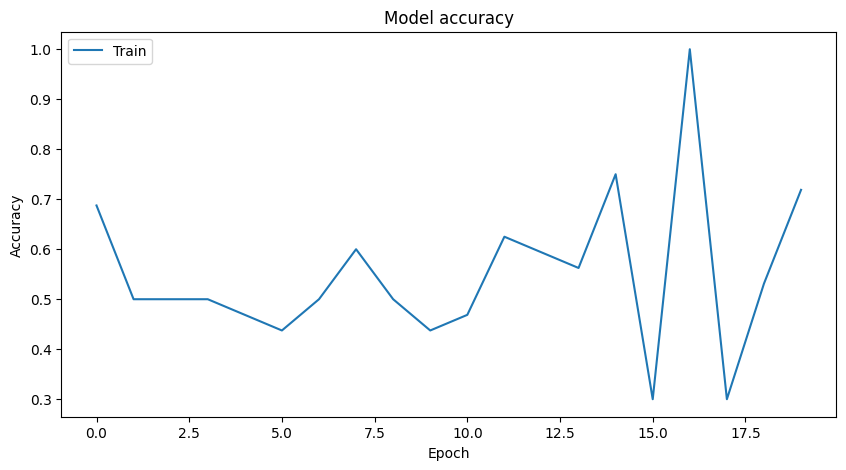

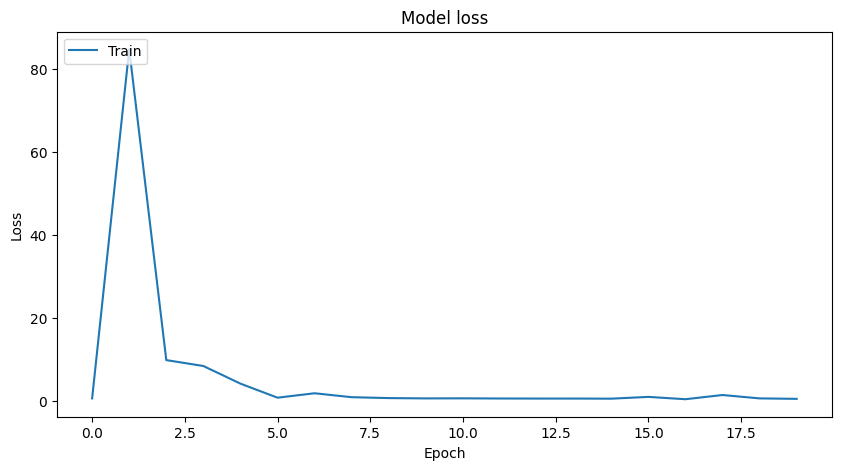

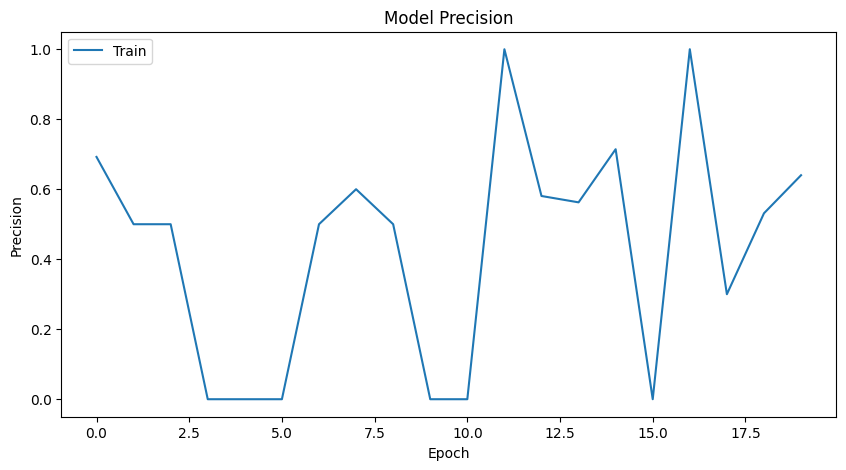

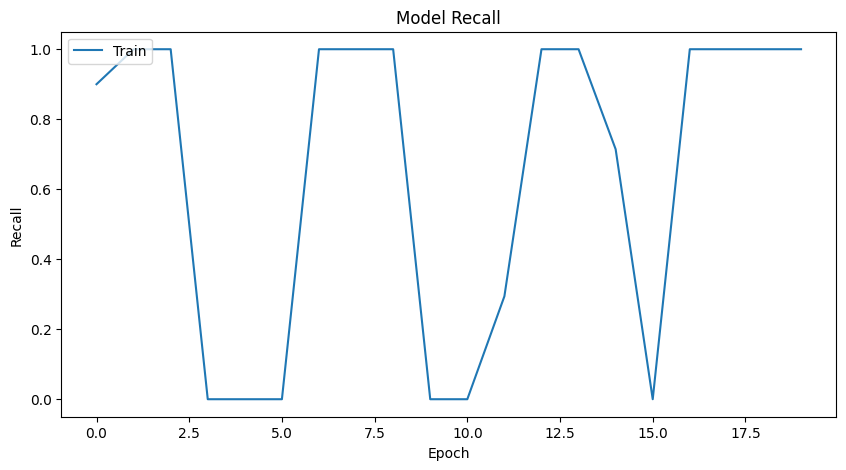

In [10]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
loss = log_loss(to_categorical(true_classes), predictions)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Log loss: {loss:.2f}")

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Precision plot
plt.figure(figsize=(10,5))
plt.plot(history.history['precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Recall plot
plt.figure(figsize=(10,5))
plt.plot(history.history['recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()